# Klassifikation mit Hidden Markov Modellen

In [1]:
import os
import sys
import time
import numpy as np

from itertools import combinations, product
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from Utils.classification_helper import MyoHmmClassifier
from Utils.data_preparation_helper import load_data_for_classification, prepare_data
from Utils.data_evaluation_helper import parse_classification_report, report_to_latex_table

In [3]:
random_seed = 42

In [4]:
def print_confusion_matrix_colored(confusion_matrix, c_labels, xy_labelsize, c_labelsize, save=None):
    fig = plt.figure(figsize=(10,10))
    ax  = fig.add_subplot(111)
    #ax.set_title('Classification report')
    ax.set_xlabel('prädizierte Klasse', fontsize=xy_labelsize, labelpad=12)
    ax.xaxis.tick_top()
    ax.set_xticks(list(range(len(c_labels))))
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticklabels(c_labels, fontsize=c_labelsize, rotation=90)

    ax.set_ylabel('tatsächliche Klasse', fontsize=xy_labelsize)
    ax.yaxis.set_ticklabels(c_labels, fontsize=c_labelsize)
    ax.set_yticks(list(range(len(c_labels))))

    img = ax.imshow(confusion_matrix, cmap='gray')
    cbar = fig.colorbar(img)
    cbar.ax.tick_params(labelsize=c_labelsize)
    fig.tight_layout()
    if save != None:
        fig.savefig(save)
    plt.show()

## Auswertung der optimalen Parameter - own

In [5]:
##### own #####
#(0.734375, 3, 1)
#(0.6875, 6, 1)
#(0.5625, 1, 1)
#(0.5, 7, 1)

acc_frames = 3
acc_states = 1

gyro_frames = 6
gyro_states = 1

ori_frames = 1
ori_states = 1

emg_frames = 7
emg_states = 1

In [6]:
start_time = time.time()

train, valid, test = load_data_for_classification('own')

acc_train_input, acc_train_label = prepare_data(train, acc_frames, 'accelerometer', verbose=False)
acc_valid_input, acc_valid_label = prepare_data(valid, acc_frames, 'accelerometer', verbose=False)
acc_test_input, acc_test_label = prepare_data(test, acc_frames, 'accelerometer', verbose=False)
print('Accelerometer data prepared')

gyro_train_input, gyro_train_label = prepare_data(train, gyro_frames, 'gyro', verbose=False)
gyro_valid_input, gyro_valid_label = prepare_data(valid, gyro_frames, 'gyro', verbose=False)
gyro_test_input, gyro_test_label = prepare_data(test, gyro_frames, 'gyro', verbose=False)
print('Gyroscope data prepared')

ori_train_input, ori_train_label = prepare_data(train, ori_frames, 'orientation', verbose=False)
ori_valid_input, ori_valid_label = prepare_data(valid, ori_frames, 'orientation', verbose=False)
ori_test_input, ori_test_label = prepare_data(test, ori_frames, 'orientation', verbose=False)
print('Orientation data prepared')

emg_train_input, emg_train_label = prepare_data(train, emg_frames, 'emg', verbose=False)
emg_valid_input, emg_valid_label = prepare_data(valid, emg_frames, 'emg', verbose=False)
emg_test_input, emg_test_label = prepare_data(test, emg_frames, 'emg', verbose=False)
print('EMG data prepared')

print('\nDuration: {}'.format(time.time() - start_time))

Accelerometer data prepared
Gyroscope data prepared
Orientation data prepared
EMG data prepared

Duration: 15.871142387390137


In [7]:
start_time = time.time()

acc_hmm = MyoHmmClassifier(sensor_type='accelerometer', n_states_per_hmm=acc_states, random_state=random_seed)
acc_hmm.fit(np.append(acc_train_input, acc_valid_input, axis=0), np.append(acc_train_label, acc_valid_label))
print('Accelerometer classifier fitted')

gyro_hmm = MyoHmmClassifier(sensor_type='gyro', n_states_per_hmm=gyro_states, random_state=random_seed)
gyro_hmm.fit(np.append(gyro_train_input, gyro_valid_input, axis=0), np.append(gyro_train_label, gyro_valid_label))
print('Gyroscope classifier fitted')

ori_hmm = MyoHmmClassifier(sensor_type='orientation', n_states_per_hmm=ori_states, random_state=random_seed)
ori_hmm.fit(np.append(ori_train_input, ori_valid_input, axis=0), np.append(ori_train_label, ori_valid_label))
print('Orientation classifier fitted')

emg_hmm = MyoHmmClassifier(sensor_type='emg', n_states_per_hmm=emg_states, random_state=random_seed)
emg_hmm.fit(np.append(emg_train_input, emg_valid_input, axis=0), np.append(emg_train_label, emg_valid_label))
print('EMG classifier fitted')

print('\nDuration: {}'.format(time.time() - start_time))

Accelerometer classifier fitted
Gyroscope classifier fitted
Orientation classifier fitted
EMG classifier fitted

Duration: 0.2235579490661621


In [8]:
frame_config ={'acc_frames':acc_frames, 'gyro_frames':gyro_frames, 'ori_frames':ori_frames, 'emg_frames':emg_frames}

save_path = '../Data/models/hmm/'
os.makedirs(save_path, exist_ok=True)

joblib.dump(acc_hmm, save_path + 'own_acc_hmm.p')
joblib.dump(gyro_hmm, save_path + 'own_gyro_hmm.p')
joblib.dump(ori_hmm, save_path + 'own_ori_hmm.p')
joblib.dump(emg_hmm, save_path + 'own_emg_hmm.p')

joblib.dump(frame_config, save_path + 'own_frame_config.p')

acc_hmm = joblib.load(save_path + 'own_acc_hmm.p')
gyro_hmm = joblib.load(save_path + 'own_gyro_hmm.p')
ori_hmm = joblib.load(save_path + 'own_ori_hmm.p')
emg_hmm = joblib.load(save_path + 'own_emg_hmm.p')

frame_config = joblib.load(save_path + 'own_frame_config.p')

In [9]:
start_time = time.time()

acc_pred_score = acc_hmm.score(acc_test_input)
gyro_pred_score = gyro_hmm.score(gyro_test_input)
ori_pred_score = ori_hmm.score(ori_test_input)
emg_pred_score = emg_hmm.score(emg_test_input)

#print(acc_pred_score)

result = []

for prediction in range(len(acc_pred_score)):
    
    interim_result = []
    
    for class_ in range(len(acc_pred_score[prediction])):
        
        if (acc_pred_score[prediction][class_][1] == gyro_pred_score[prediction][class_][1] and
            gyro_pred_score[prediction][class_][1] == ori_pred_score[prediction][class_][1] and
            ori_pred_score[prediction][class_][1] == emg_pred_score[prediction][class_][1]):
            
            acc_gyro = np.add(acc_pred_score[prediction][class_][0], gyro_pred_score[prediction][class_][0])
            ori_emg = np.add(ori_pred_score[prediction][class_][0], emg_pred_score[prediction][class_][0])
            final = np.divide(np.add(acc_gyro, ori_emg), 4)
            interim_result.append((final, acc_pred_score[prediction][class_][1]))
        
        else:
            print('Something went wrong!')
    
    result.append(max(interim_result)[1])
    
#print(result)

print('\nDuration: {}'.format(time.time() - start_time))


Duration: 0.49207091331481934


In [10]:
print(accuracy_score(acc_test_label, result))

0.815384615385


[[ 9  0  0  0  0  0]
 [ 0  9  0  0  0  0]
 [ 0  0  9  0  0  2]
 [ 2  2  0  8  0  0]
 [ 0  1  1  0 10  0]
 [ 4  0  0  0  0  8]]


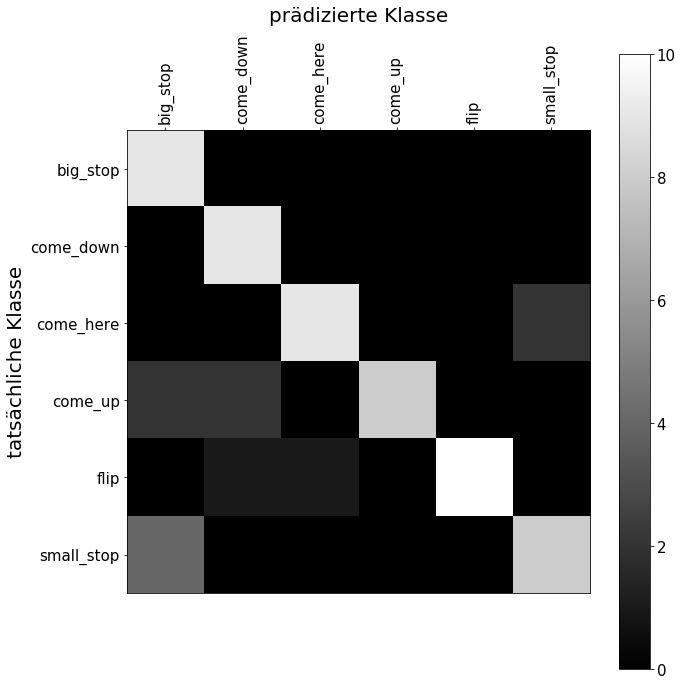

In [11]:
cm = confusion_matrix(acc_test_label, result)

labels = list(acc_hmm._class_mapping.keys())

print(cm)
   
print_confusion_matrix_colored(cm, labels, 20, 15)

In [12]:
clf_repo = classification_report(acc_test_label, result)

print(clf_repo)

parsed = parse_classification_report(clf_repo)
output = report_to_latex_table(parsed)
#print(output)

             precision    recall  f1-score   support

   big_stop       0.60      1.00      0.75         9
  come_down       0.75      1.00      0.86         9
  come_here       0.90      0.82      0.86        11
    come_up       1.00      0.67      0.80        12
       flip       1.00      0.83      0.91        12
 small_stop       0.80      0.67      0.73        12

avg / total       0.86      0.82      0.82        65



## Auswertung der optimalen Parameter - paper

In [13]:
##### paper #####
#(0.20618556701030927, 6, 2)
#(0.25257731958762886, 2, 2)
#(0.11855670103092783, 3, 1)
#(0.14432989690721648, 11, 1)

acc_frames = 6
acc_states = 2

gyro_frames = 2
gyro_states = 2

ori_frames = 3
ori_states = 1

emg_frames = 11
emg_states = 1

In [14]:
start_time = time.time()

train, valid, test = load_data_for_classification('paper')

acc_train_input, acc_train_label = prepare_data(train, acc_frames, 'accelerometer', verbose=False)
acc_valid_input, acc_valid_label = prepare_data(valid, acc_frames, 'accelerometer', verbose=False)
acc_test_input, acc_test_label = prepare_data(test, acc_frames, 'accelerometer', verbose=False)
print('Accelerometer data prepared')

gyro_train_input, gyro_train_label = prepare_data(train, gyro_frames, 'gyro', verbose=False)
gyro_valid_input, gyro_valid_label = prepare_data(valid, gyro_frames, 'gyro', verbose=False)
gyro_test_input, gyro_test_label = prepare_data(test, gyro_frames, 'gyro', verbose=False)
print('Gyroscope data prepared')

ori_train_input, ori_train_label = prepare_data(train, ori_frames, 'orientation', verbose=False)
ori_valid_input, ori_valid_label = prepare_data(valid, ori_frames, 'orientation', verbose=False)
ori_test_input, ori_test_label = prepare_data(test, ori_frames, 'orientation', verbose=False)
print('Orientation data prepared')

emg_train_input, emg_train_label = prepare_data(train, emg_frames, 'emg', verbose=False)
emg_valid_input, emg_valid_label = prepare_data(valid, emg_frames, 'emg', verbose=False)
emg_test_input, emg_test_label = prepare_data(test, emg_frames, 'emg', verbose=False)
print('EMG data prepared')

print('\nDuration: {}'.format(time.time() - start_time))

Accelerometer data prepared
Gyroscope data prepared
Orientation data prepared
EMG data prepared

Duration: 77.91993761062622


In [15]:
start_time = time.time()

acc_hmm = MyoHmmClassifier(sensor_type='accelerometer', n_states_per_hmm=acc_states, random_state=random_seed)
acc_hmm.fit(np.append(acc_train_input, acc_valid_input, axis=0), np.append(acc_train_label, acc_valid_label))
print('Accelerometer classifier fitted')

gyro_hmm = MyoHmmClassifier(sensor_type='gyro', n_states_per_hmm=gyro_states, random_state=random_seed)
gyro_hmm.fit(np.append(gyro_train_input, gyro_valid_input, axis=0), np.append(gyro_train_label, gyro_valid_label))
print('Gyroscope classifier fitted')

ori_hmm = MyoHmmClassifier(sensor_type='orientation', n_states_per_hmm=ori_states, random_state=random_seed)
ori_hmm.fit(np.append(ori_train_input, ori_valid_input, axis=0), np.append(ori_train_label, ori_valid_label))
print('Orientation classifier fitted')

emg_hmm = MyoHmmClassifier(sensor_type='emg', n_states_per_hmm=emg_states, random_state=random_seed)
emg_hmm.fit(np.append(emg_train_input, emg_valid_input, axis=0), np.append(emg_train_label, emg_valid_label))
print('EMG classifier fitted')

print('\nDuration: {}'.format(time.time() - start_time))

Accelerometer classifier fitted
Gyroscope classifier fitted
Orientation classifier fitted
EMG classifier fitted

Duration: 0.969733476638794


In [16]:
frame_config ={'acc_frames':acc_frames, 'gyro_frames':gyro_frames, 'ori_frames':ori_frames, 'emg_frames':emg_frames}

save_path = '../Data/models/hmm/'
os.makedirs(save_path, exist_ok=True)

joblib.dump(acc_hmm, save_path + 'paper_acc_hmm.p')
joblib.dump(gyro_hmm, save_path + 'paper_gyro_hmm.p')
joblib.dump(ori_hmm, save_path + 'paper_ori_hmm.p')
joblib.dump(emg_hmm, save_path + 'paper_emg_hmm.p')

joblib.dump(frame_config, save_path + 'paper_frame_config.p')

acc_hmm = joblib.load(save_path + 'paper_acc_hmm.p')
gyro_hmm = joblib.load(save_path + 'paper_gyro_hmm.p')
ori_hmm = joblib.load(save_path + 'paper_ori_hmm.p')
emg_hmm = joblib.load(save_path + 'paper_emg_hmm.p')

frame_config = joblib.load(save_path + 'paper_frame_config.p')

In [17]:
start_time = time.time()

acc_pred_score = acc_hmm.score(acc_test_input)
gyro_pred_score = gyro_hmm.score(gyro_test_input)
ori_pred_score = ori_hmm.score(ori_test_input)
emg_pred_score = emg_hmm.score(emg_test_input)

#print(acc_pred_score)

result = []

for prediction in range(len(acc_pred_score)):
    
    interim_result = []
    
    for class_ in range(len(acc_pred_score[prediction])):
        
        if (acc_pred_score[prediction][class_][1] == gyro_pred_score[prediction][class_][1] and
            gyro_pred_score[prediction][class_][1] == ori_pred_score[prediction][class_][1] and
            ori_pred_score[prediction][class_][1] == emg_pred_score[prediction][class_][1]):
            
            acc_gyro = np.add(acc_pred_score[prediction][class_][0], gyro_pred_score[prediction][class_][0])
            ori_emg = np.add(ori_pred_score[prediction][class_][0], emg_pred_score[prediction][class_][0])
            final = np.divide(np.add(acc_gyro, ori_emg), 4)
            interim_result.append((final, acc_pred_score[prediction][class_][1]))
        
        else:
            print('Something went wrong!')
    
    result.append(max(interim_result)[1])
    
#print(result)

print('\nDuration: {}'.format(time.time() - start_time))


Duration: 4.546392440795898


In [18]:
print(accuracy_score(acc_test_label, result))

0.288659793814


[[1 0 2 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 0 4 0 0 1 0 0 0 0 0 0 0 0 4 0 0 0]
 [0 0 4 4 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 7 0 0 1 0 0 0 0 0 0 1 0 0 0]
 [0 0 6 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 2 0 0 3 0 0 1 0 0 2 0 0 0 0 1]
 [0 1 0 0 0 0 0 5 0 0 1 0 0 0 2 0 1 1]
 [0 0 0 0 0 0 3 0 1 2 0 0 0 0 6 0 0 0]
 [0 0 1 3 0 0 0 0 0 3 0 0 0 0 2 0 0 3]
 [0 1 0 0 0 0 0 3 0 0 3 0 0 0 1 0 2 2]
 [0 0 0 0 0 0 0 1 4 0 0 1 0 0 3 0 0 3]
 [0 0 1 6 0 0 1 0 0 1 0 0 2 0 0 0 0 1]
 [0 3 0 0 0 0 0 1 0 0 1 0 0 2 1 0 1 3]
 [0 0 4 0 0 0 0 0 0 0 0 0 0 0 6 0 0 2]
 [0 0 2 7 0 0 0 0 0 1 0 0 1 0 0 0 0 1]
 [0 1 0 0 2 0 0 0 0 0 1 0 0 0 0 0 6 2]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 7 0 0 2]]


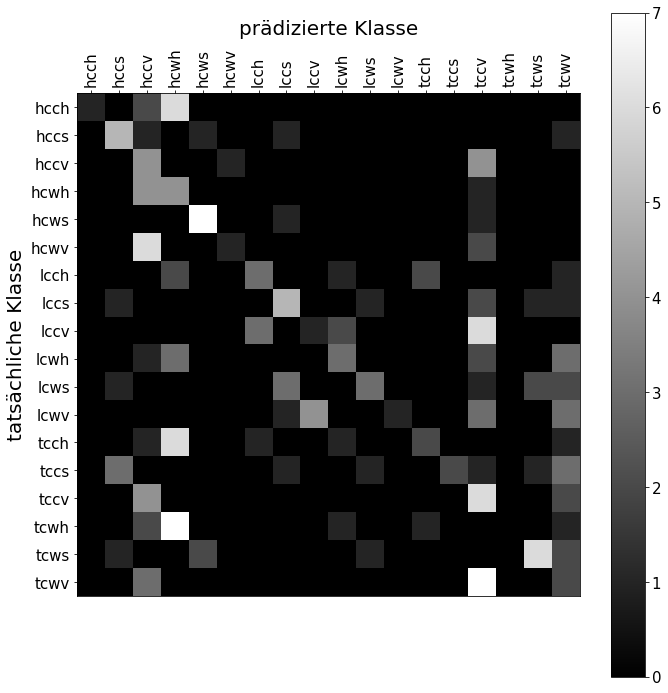

In [19]:
cm = confusion_matrix(acc_test_label, result)
labels = list(acc_hmm._class_mapping.keys())

print(cm)

print_confusion_matrix_colored(cm, labels, 20, 15)

In [20]:
clf_repo = classification_report(acc_test_label, result)

print(clf_repo)

parsed = parse_classification_report(clf_repo)
output = report_to_latex_table(parsed)
#print(output)

             precision    recall  f1-score   support

       hcch       1.00      0.11      0.20         9
       hccs       0.45      0.56      0.50         9
       hccv       0.14      0.44      0.22         9
       hcwh       0.14      0.44      0.22         9
       hcws       0.70      0.78      0.74         9
       hcwv       0.50      0.11      0.18         9
       lcch       0.43      0.33      0.38         9
       lccs       0.42      0.45      0.43        11
       lccv       0.20      0.08      0.12        12
       lcwh       0.38      0.25      0.30        12
       lcws       0.50      0.25      0.33        12
       lcwv       1.00      0.08      0.15        12
       tcch       0.40      0.17      0.24        12
       tccs       1.00      0.17      0.29        12
       tccv       0.17      0.50      0.25        12
       tcwh       0.00      0.00      0.00        12
       tcws       0.60      0.50      0.55        12
       tcwv       0.09      0.17      0.12   

## Auswertung der optimalen Parameter - all

In [21]:
##### all #####
#(0.28185328185328185, 4, 1)
#(0.30888030888030887, 8, 1)
#(0.15444015444015444, 3, 1)
#(0.20077220077220076, 11, 1)

acc_frames = 4
acc_states = 1

gyro_frames = 6
gyro_states = 1

ori_frames = 3
ori_states = 1

emg_frames = 11
emg_states = 1

In [22]:
start_time = time.time()

train, valid, test = load_data_for_classification('all')

acc_train_input, acc_train_label = prepare_data(train, acc_frames, 'accelerometer', verbose=False)
acc_valid_input, acc_valid_label = prepare_data(valid, acc_frames, 'accelerometer', verbose=False)
acc_test_input, acc_test_label = prepare_data(test, acc_frames, 'accelerometer', verbose=False)
print('Accelerometer data prepared')

gyro_train_input, gyro_train_label = prepare_data(train, gyro_frames, 'gyro', verbose=False)
gyro_valid_input, gyro_valid_label = prepare_data(valid, gyro_frames, 'gyro', verbose=False)
gyro_test_input, gyro_test_label = prepare_data(test, gyro_frames, 'gyro', verbose=False)
print('Gyroscope data prepared')

ori_train_input, ori_train_label = prepare_data(train, ori_frames, 'orientation', verbose=False)
ori_valid_input, ori_valid_label = prepare_data(valid, ori_frames, 'orientation', verbose=False)
ori_test_input, ori_test_label = prepare_data(test, ori_frames, 'orientation', verbose=False)
print('Orientation data prepared')

emg_train_input, emg_train_label = prepare_data(train, emg_frames, 'emg', verbose=False)
emg_valid_input, emg_valid_label = prepare_data(valid, emg_frames, 'emg', verbose=False)
emg_test_input, emg_test_label = prepare_data(test, emg_frames, 'emg', verbose=False)
print('EMG data prepared')

print('\nDuration: {}'.format(time.time() - start_time))

Accelerometer data prepared
Gyroscope data prepared
Orientation data prepared
EMG data prepared

Duration: 94.34784531593323


In [23]:
start_time = time.time()

acc_hmm = MyoHmmClassifier(sensor_type='accelerometer', n_states_per_hmm=acc_states, random_state=random_seed)
acc_hmm.fit(np.append(acc_train_input, acc_valid_input, axis=0), np.append(acc_train_label, acc_valid_label))
print('Accelerometer classifier fitted')

gyro_hmm = MyoHmmClassifier(sensor_type='gyro', n_states_per_hmm=gyro_states, random_state=random_seed)
gyro_hmm.fit(np.append(gyro_train_input, gyro_valid_input, axis=0), np.append(gyro_train_label, gyro_valid_label))
print('Gyroscope classifier fitted')

ori_hmm = MyoHmmClassifier(sensor_type='orientation', n_states_per_hmm=ori_states, random_state=random_seed)
ori_hmm.fit(np.append(ori_train_input, ori_valid_input, axis=0), np.append(ori_train_label, ori_valid_label))
print('Orientation classifier fitted')

emg_hmm = MyoHmmClassifier(sensor_type='emg', n_states_per_hmm=emg_states, random_state=random_seed)
emg_hmm.fit(np.append(emg_train_input, emg_valid_input, axis=0), np.append(emg_train_label, emg_valid_label))
print('EMG classifier fitted')

print('\nDuration: {}'.format(time.time() - start_time))

Accelerometer classifier fitted
Gyroscope classifier fitted
Orientation classifier fitted
EMG classifier fitted

Duration: 0.9009068012237549


In [24]:
frame_config ={'acc_frames':acc_frames, 'gyro_frames':gyro_frames, 'ori_frames':ori_frames, 'emg_frames':emg_frames}

save_path = '../Data/models/hmm/'
os.makedirs(save_path, exist_ok=True)

joblib.dump(acc_hmm, save_path + 'all_acc_hmm.p')
joblib.dump(gyro_hmm, save_path + 'all_gyro_hmm.p')
joblib.dump(ori_hmm, save_path + 'all_ori_hmm.p')
joblib.dump(emg_hmm, save_path + 'all_emg_hmm.p')

joblib.dump(frame_config, save_path + 'all_frame_config.p')

acc_hmm = joblib.load(save_path + 'all_acc_hmm.p')
gyro_hmm = joblib.load(save_path + 'all_gyro_hmm.p')
ori_hmm = joblib.load(save_path + 'all_ori_hmm.p')
emg_hmm = joblib.load(save_path + 'all_emg_hmm.p')

frame_config = joblib.load(save_path + 'all_frame_config.p')

In [25]:
start_time = time.time()

acc_pred_score = acc_hmm.score(acc_test_input)
gyro_pred_score = gyro_hmm.score(gyro_test_input)
ori_pred_score = ori_hmm.score(ori_test_input)
emg_pred_score = emg_hmm.score(emg_test_input)

#print(acc_pred_score)

result = []

for prediction in range(len(acc_pred_score)):
    
    interim_result = []
    
    for class_ in range(len(acc_pred_score[prediction])):
        
        if (acc_pred_score[prediction][class_][1] == gyro_pred_score[prediction][class_][1] and
            gyro_pred_score[prediction][class_][1] == ori_pred_score[prediction][class_][1] and
            ori_pred_score[prediction][class_][1] == emg_pred_score[prediction][class_][1]):
            
            acc_gyro = np.add(acc_pred_score[prediction][class_][0], gyro_pred_score[prediction][class_][0])
            ori_emg = np.add(ori_pred_score[prediction][class_][0], emg_pred_score[prediction][class_][0])
            final = np.divide(np.add(acc_gyro, ori_emg), 4)
            interim_result.append((final, acc_pred_score[prediction][class_][1]))
        
        else:
            print('Something went wrong!')
    
    result.append(max(interim_result)[1])
    
#print(result)

print('\nDuration: {}'.format(time.time() - start_time))


Duration: 7.537582159042358


In [26]:
print(accuracy_score(acc_test_label, result))

0.416988416988


[[ 8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  7  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 1  1  0  4  0  0  0  0  1  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  1  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  1  3  0  0  0  0  0  0  0  0  0  0  0  1  0  0  2]
 [ 0  0  0  0  0  0  5  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  1]
 [ 0  0  0  0  0  2  0  3  2  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  4  0  0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  5  1  0  1  0  0  0  0  0  0  0  0  0  3  0  0  2]
 [ 0  0  0  0  0  4  0  0  1  0  0  5  0  0  0  0  0  0  1  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  1  0  0  0  0  2  0  1  1]
 [ 0  0  0  0  0  0  0  0

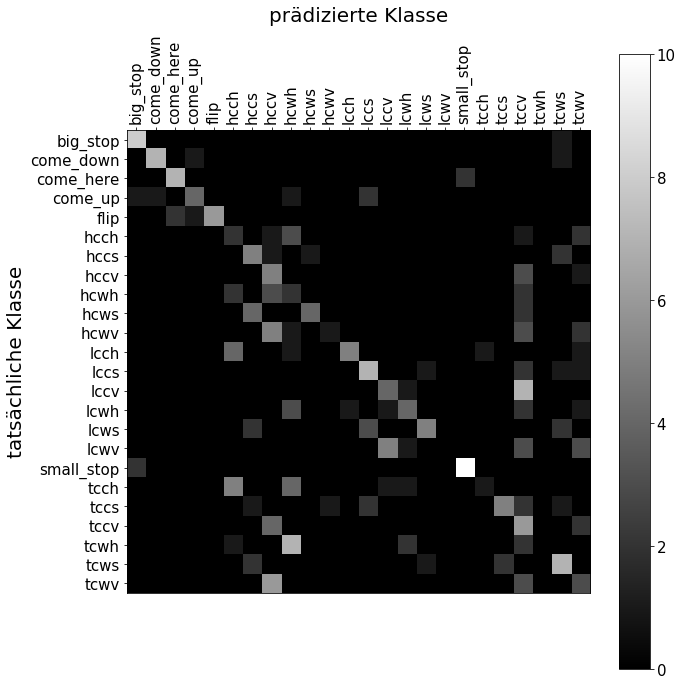

In [27]:
cm = confusion_matrix(acc_test_label, result)
labels = list(acc_hmm._class_mapping.keys())

print(cm)

print_confusion_matrix_colored(cm, labels, 20, 15)

In [28]:
clf_repo = classification_report(acc_test_label, result)

print(clf_repo)

parsed = parse_classification_report(clf_repo)
output = report_to_latex_table(parsed)
#print(output)

             precision    recall  f1-score   support

   big_stop       0.73      0.89      0.80         9
  come_down       0.88      0.78      0.82         9
  come_here       0.78      0.78      0.78         9
    come_up       0.67      0.44      0.53         9
       flip       1.00      0.67      0.80         9
       hcch       0.14      0.22      0.17         9
       hccs       0.36      0.56      0.43         9
       hccv       0.20      0.56      0.29         9
       hcwh       0.09      0.22      0.13         9
       hcws       0.80      0.40      0.53        10
       hcwv       0.50      0.08      0.14        12
       lcch       0.83      0.42      0.56        12
       lccs       0.50      0.58      0.54        12
       lccv       0.36      0.33      0.35        12
       lcwh       0.44      0.33      0.38        12
       lcws       0.71      0.42      0.53        12
       lcwv       0.00      0.00      0.00        12
 small_stop       0.83      0.83      0.83   